In [1]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score

In [4]:
df = pd.read_csv("all_data.csv", encoding='utf-8')

In [5]:
df.head()

,state,education,year,state_legislature,governor,lt_governor,labour_force_participation,mngmt_job_wage_gap,bachelor_wage_gap,ab_legality,rape_rate,sex_ratio_birth,abortion_rate,life_exp_f_m
0,Alabama,1.180,2020,0.157,1.0,0.0,0.782,0.640,25.1,0,32.7,1.068376,113.548,1.089325
1,Alaska,1.014,2020,0.367,0.0,0.0,0.795,0.779,18.1,1,154.8,0.915751,164.547,1.066098
2,Arizona,1.112,2020,0.389,0.0,0.0,0.789,0.701,23.2,1,44.0,1.012146,184.862,1.083424
3,Arkansas,1.115,2020,0.259,0.0,0.0,0.837,0.705,20.1,0,73.5,1.037344,104.638,1.077586
4,California,1.099,2020,0.308,0.0,1.0,0.764,0.734,18.6,1,34.2,1.011122,16.075,1.076426


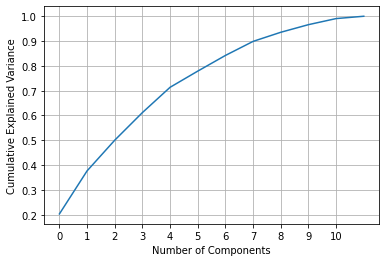

In [6]:
# 加载数据
X= df[[ 'education',  'state_legislature',
       'governor', 'lt_governor', 'labour_force_participation',
       'mngmt_job_wage_gap', 'bachelor_wage_gap', 'ab_legality',
       'life_exp_f_m', 'sex_ratio_birth', 'abortion_rate', 'year'
       ]]
y= df['rape_rate']
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
# 计算PCA
pca = PCA()
pca.fit(X)

# 绘制PCA曲线
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(np.arange(0, 11, 1))
plt.grid()
plt.show()

In [7]:
# PCA shows when component==7, cumulative explained variance is 0.9

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 创建PCR模型
model = Pipeline(steps=[('pca', PCA(n_components=7)),
                        ('regression', LinearRegression())])

# 拟合模型
model.fit(X_train, y_train)

# 预测
model.score(X_test,y_test)

0.4272743446240099

#### Random Forest Regressor

In [11]:
model = RandomForestRegressor(n_estimators=500, random_state=42, max_depth=10)
model.fit(X_train, y_train)
model.score(X_test, y_test)
r2 = model.score(X_test, y_test)
print('r2: ', r2)
n = len(y_test)
k = X_test.shape[1]
adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
print('adjusted_r2: ', adj_r2) 

r2:  0.773756750100723
adjusted_r2:  0.7539398231022462


### Linear Regression

In [12]:
# 假设 X_train, X_test, y_train, y_test 分别表示训练集和测试集的自变量和因变量
model = LinearRegression()
model.fit(X_train, y_train)
r2 = model.score(X_test, y_test)
print('r2: ', r2)
n = len(y_test)
k = X_test.shape[1]
adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
print('adjusted_r2: ', adj_r2)

r2:  0.4705402909334574
adjusted_r2:  0.42416425802251934
